In [88]:
import os
import tqdm
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torch.utils.data.sampler import SubsetRandomSampler, WeightedRandomSampler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc
from scipy import interp
from itertools import cycle

In [78]:
def encode_seq(seq):
    encoding_list = []
    for i in range(len(seq)):
        if seq[i] == "*":
            encoding_list.append(np.zeros(5).reshape(1,5))
        elif seq[i] == "_":
            # print("Error: seqCDR contains '_'")
            # encoding_list.append(np.zeros(5).reshape(1,5))
            return np.nan
        else:
            encoding_list.append(af.loc[seq[i]].values.reshape(1,5))
    return np.array(encoding_list).reshape(1,-1)

af = pd.read_csv("~/data/project/pMHC-TCR/library/Atchley_factors.csv")
af.index = af["Amino acid"]
af.drop(columns=["Amino acid"], inplace=True)

In [86]:
class TCREncodeData(Dataset):
    def __init__(self, file_path):
        df = pd.read_csv(file_path, index_col=0)
        # just use the positive samples
        df = df[df["Class"] == "positive"]
        df = df.drop_duplicates(subset=["AseqCDR3", "BseqCDR3"], keep="first")

        df = df.loc[df["AseqCDR3"].str.len() < 40, :]
        df = df.loc[df["BseqCDR3"].str.len() < 40, :]

        len_map = {
            "AseqCDR3": df["AseqCDR3"].apply(lambda x: len(x)).max(),
            "BseqCDR3": df["BseqCDR3"].apply(lambda x: len(x)).max(),
        }
        print(len_map)
        
        for chain in ["AseqCDR3", "BseqCDR3"]:
            length = len_map[chain]
            df[chain] = df[chain].apply(
                lambda x: x + "*" * (length - len(x))
            )
            df[chain] = df[chain].apply(lambda x: encode_seq(x))

        df = df.dropna()
        print(df.shape)

        X = torch.zeros((len(df), 0))
        for seq in ["AseqCDR3", "BseqCDR3"]:
            X = torch.cat((X, torch.from_numpy(
                np.vstack(df[seq].values)
            )), dim=1)
        
        y = df["Class"].apply(lambda x: 1 if x == "positive" else 0).values

        self.X = X
        self.y = torch.from_numpy(y).float()
        self.Aseq_len = len_map["AseqCDR3"]
        self.Bseq_len = len_map["BseqCDR3"]

    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [87]:
file_path = "~/data/project/data/seqData/20230228.csv"
TCRData = TCREncodeData(file_path)

{'AseqCDR3': 25, 'BseqCDR3': 21}
(787, 5)


# TCR autoencoder discrete

In [140]:
class TCR_a_autoencoder(nn.Module):
    def __init__(self, kernel_size=3, stride=2, padding=1, batch_size=16):
        super(TCR_a_autoencoder, self).__init__()
        self.batch_size = batch_size
        self.encoder = nn.Sequential(
            # (W + 2P - K)/S + 1
            # (batch_size, 5, 25)
            nn.Conv1d(5, 7, kernel_size=kernel_size, stride=stride, padding=padding),
            # (batch_size, 7, 13)
            nn.LeakyReLU(),
            
            nn.Conv1d(7, 8, kernel_size=kernel_size, stride=stride, padding=padding),
            # (batch_size, 8, 7)
            nn.LeakyReLU(),

            nn.Conv1d(8, 9, kernel_size=5, stride=stride, padding=padding),
            # (batch_size, 9, 3)
            nn.LeakyReLU(),

            nn.Conv1d(9, 10, kernel_size=5, stride=stride, padding=padding),
            nn.LeakyReLU(),
            # (batch_size, 10, 1)
        )

        self.decoder = nn.Sequential(
            # (w-1)S-2P+F
            # (batch_size, 10, 1)
            nn.ConvTranspose1d(10, 9, kernel_size=3, stride=2, padding=0),
            # (batch_size, 9, 3)
            nn.LeakyReLU(),
            
            nn.ConvTranspose1d(9, 8, kernel_size=3, stride=2, padding=0),
            # (batch_size, 8, 7)
            nn.LeakyReLU(),

            nn.ConvTranspose1d(8, 7, kernel_size=3, stride=2, padding=1),
            # (batch_size, 7, 13)
            nn.LeakyReLU(),

            nn.ConvTranspose1d(7, 5, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(),
            # (batch_size, 5, 25)
        )
    
    def forward(self, input):
        x = input.float()
        encoded = self.encoder(x)
        encoded = encoded.float()
        output = self.decoder(encoded)
        return encoded, output

In [141]:
class TCR_b_autoencoder(nn.Module):
    def __init__(self, kernel_size=3, stride=2, padding=1, batch_size=16):
        super(TCR_b_autoencoder, self).__init__()
        self.batch_size = batch_size
        self.encoder = nn.Sequential(
            # (W + 2P - K)/S + 1
            # (batch_size, 5, 21)
            nn.Conv1d(5, 7, kernel_size=kernel_size, stride=stride, padding=padding),
            # (batch_size, 7, 11)
            nn.LeakyReLU(),

            nn.Conv1d(7, 8, kernel_size=kernel_size, stride=stride, padding=padding),
            # (batch_size, 8, 6)
            nn.LeakyReLU(),

            nn.Conv1d(8, 9, kernel_size=kernel_size, stride=stride, padding=padding),
            # (batch_size, 9, 3)
            nn.LeakyReLU(),

            nn.Conv1d(9, 10, kernel_size=5, stride=stride, padding=padding),
            # (batch_size, 10, 1)
            # nn.LeakyReLU(),
        )

        self.decoder = nn.Sequential(
            # (W-1)S-2P+F
            # (batch_size, 10, 1)
            nn.ConvTranspose1d(10, 9, kernel_size=3, stride=stride, padding=0),
            # (batch_size, 9, 3)
            nn.LeakyReLU(),

            nn.ConvTranspose1d(9, 8, kernel_size=3, stride=stride, padding=padding),
            # (batch_size, 8, 5)
            nn.LeakyReLU(),

            nn.ConvTranspose1d(8, 7, kernel_size=3, stride=stride, padding=0),
            # (batch_size, 7, 11)
            nn.LeakyReLU(),

            nn.ConvTranspose1d(7, 5, kernel_size=3, stride=stride, padding=padding),
            # (batch_size, 5, 21)
            nn.LeakyReLU(),
        )

    def forward(self, input):
        x= input.float()
        encoded = self.encoder(x)
        encoded = encoded.float()
        output = self.decoder(encoded)
        return encoded, output

In [142]:
class Discrete_ae(nn.Module):
    # this module contains the two parts of ae which could embedding the 
    def __init__(self, kernel_size=3, stride=2, padding=1, batch_size=16, seq_len_a=None, seq_len_b=None):
        super(Discrete_ae, self).__init__()
        self.ae_a = TCR_a_autoencoder(kernel_size=kernel_size, stride=stride, padding=padding, batch_size=batch_size)
        self.ae_b = TCR_b_autoencoder(kernel_size=kernel_size, stride=stride, padding=padding, batch_size=batch_size)
        self.seq_len_a = seq_len_a
        self.seq_len_b = seq_len_b
        self.batch_size = batch_size
    
    def forward(self, input):
        # input shape (batch_size, 5, 25 + 21)
        # split the input into two parts
        input_a = input[:, :, :self.seq_len_a]
        input_b = input[:, :, self.seq_len_a:]
        # print("input shape:",input_a.shape, input_b.shape)
        # encode the two parts
        encoded_a, output_a = self.ae_a(input_a)
        encoded_b, output_b = self.ae_b(input_b)
        # print("output shape", output_a.shape, output_b.shape)
        # the shape of encoded_a and encoded_b is (batch_size, 10, 1)
        # concatenate the two parts
        encoded = torch.cat((encoded_a, encoded_b), dim=1)
        output = torch.cat((output_a, output_b), dim=2)
        # the shape of encoded is (batch_size, 20, 1)
        # the shape of output is (batch_size, 5, 25 + 21)
        return encoded, output

Train Epoch: 1 [0/629 (0%)]	Loss: 1.340333
Train Epoch: 2 [0/629 (0%)]	Loss: 1.335993
Train Epoch: 3 [0/629 (0%)]	Loss: 1.318368
Train Epoch: 4 [0/629 (0%)]	Loss: 1.284252
Train Epoch: 5 [0/629 (0%)]	Loss: 1.228073
Train Epoch: 6 [0/629 (0%)]	Loss: 1.116115
Train Epoch: 7 [0/629 (0%)]	Loss: 1.302952
Train Epoch: 8 [0/629 (0%)]	Loss: 1.142032
Train Epoch: 9 [0/629 (0%)]	Loss: 1.313295
Train Epoch: 10 [0/629 (0%)]	Loss: 1.196773
Train Epoch: 11 [0/629 (0%)]	Loss: 1.226517
Train Epoch: 12 [0/629 (0%)]	Loss: 1.284943
Train Epoch: 13 [0/629 (0%)]	Loss: 1.104113
Train Epoch: 14 [0/629 (0%)]	Loss: 1.077351
Train Epoch: 15 [0/629 (0%)]	Loss: 1.111689
Train Epoch: 16 [0/629 (0%)]	Loss: 1.060146
Train Epoch: 17 [0/629 (0%)]	Loss: 1.094539
Train Epoch: 18 [0/629 (0%)]	Loss: 0.996468
Train Epoch: 19 [0/629 (0%)]	Loss: 1.094022
Train Epoch: 20 [0/629 (0%)]	Loss: 1.045444
Train Epoch: 21 [0/629 (0%)]	Loss: 0.961183
Train Epoch: 22 [0/629 (0%)]	Loss: 1.016657
Train Epoch: 23 [0/629 (0%)]	Loss: 0.9661

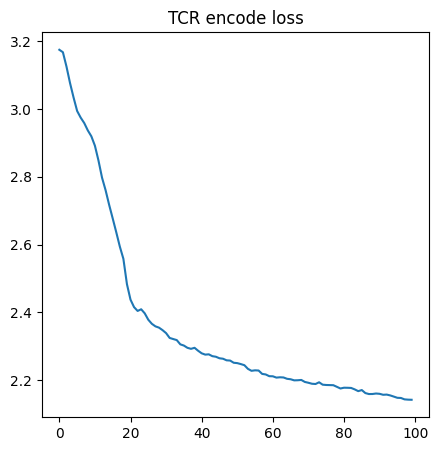

In [143]:
def train_ae(model, train_loader, optimizer, criterion, epoch, seq_len):
    model.train()
    batch_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.float()
        data = data.view(batch_size, 5, seq_len)
        optimizer.zero_grad()
        _, output = model(data)
        # print(output.shape, data.shape)
        loss = criterion(output, data)
        batch_loss += loss.item()
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))
        
    return batch_loss / len(data)

epochs = 100
batch_size = 16
learning_rate = 1e-3
kernel_size = 3
stride = 2
padding = 1
seq_len_a = TCRData.Aseq_len
seq_len_b = TCRData.Bseq_len

# train the autoencoder
model = Discrete_ae(kernel_size=kernel_size, stride=stride, 
            padding=padding, batch_size=batch_size, 
            seq_len_a=seq_len_a, seq_len_b=seq_len_b)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_data, test_data = torch.utils.data.random_split(TCRData, 
                         lengths=[int(np.floor(len(TCRData)*0.8)), int(np.ceil(len(TCRData)*0.2))])
train_data = Subset(TCRData, train_data.indices)
test_data = Subset(TCRData, test_data.indices)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)

# plot the loss 
fig, ax = plt.subplots(1, 1, figsize=(5,5))

# plot the loss
TCR_encode_losses = []
TCR_accuracy = 0
for epoch in range(1, epochs + 1):
    TCR_encode_loss = train_ae(model, train_loader, optimizer, criterion, epoch, seq_len_a+seq_len_b)
    TCR_encode_losses.append(TCR_encode_loss)
ax.set_title("TCR encode loss")
ax.plot(TCR_encode_losses, label="TCR encode loss")

In [136]:
# test
# int(np.floor(len(TCRData)*0.8)) + int(np.ceil(len(TCRData)*0.2))
a = train_data[0][0]
a = a.view(1, 5, 25+21)
split_a = a[:, :, :25]
split_b = a[:, :, 25:]
print(split_a.shape, split_b.shape)
layer = nn.ConvTranspose1d(1 , 1, kernel_size=3, stride=stride, padding=1)
input = torch.randn(16, 1, 13)
output = layer(input)
print(output.shape)

torch.Size([1, 5, 25]) torch.Size([1, 5, 21])


In [146]:
# test the Discrete_ae
epochs = 100
batch_size = 16
learning_rate = 1e-3
kernel_size = 3
stride = 2
padding = 1

model.eval()

TCR_encode = torch.zeros((0, 20, 1))
for i in range(len(TCRData)):
    TCR_seq = TCRData[i][0]
    encode_shape = int(TCR_seq.shape[0] / 5)
    TCR_seq = TCR_seq.view(1, 5, encode_shape).float()
    encode, _ = model(TCR_seq)
    TCR_encode = torch.cat((TCR_encode, encode), dim=0)

In [148]:
TCR_encode.shape

torch.Size([787, 20, 1])